In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib 
import os 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore') 
sns.set_style('whitegrid')

In [6]:
df = pd.read_csv("../dataset/EPL_2018-2025.csv")
df.head()

,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2018/19,2018-08-10,Man United,Leicester,2,1,H,1,0,H,...,6,4,2,5,11,8,2,1,0,0
1,2018/19,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,...,4,1,7,4,11,9,1,1,0,0
2,2018/19,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,...,6,9,5,5,9,11,1,2,0,0
3,2018/19,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,...,1,4,2,5,9,8,2,1,0,0
4,2018/19,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,...,2,5,3,5,11,12,2,2,0,0


In [7]:
df['MatchDate'] = pd.to_datetime(df['MatchDate'])
df = df.sort_values(by='MatchDate').reset_index(drop=True)

print("MatchDate converted and data sorted.")
print("\nDataFrame head after sorting:")
print(df[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam']].head())

MatchDate converted and data sorted.

DataFrame head after sorting:
    Season  MatchDate      HomeTeam        AwayTeam
0  2018/19 2018-08-10    Man United       Leicester
1  2018/19 2018-08-11   Bournemouth         Cardiff
2  2018/19 2018-08-11        Fulham  Crystal Palace
3  2018/19 2018-08-11  Huddersfield         Chelsea
4  2018/19 2018-08-11     Newcastle       Tottenham


In [8]:
print("Calculating team strength/form features (rolling averages)...")

# Define the window size for rolling averages
ROLLING_WINDOW = 5

# --- get_rolling_stats_refined function ---
def get_rolling_stats_refined(team, match_date, df_sorted, window_size, location_filter=None):
    # Ensure df_sorted includes necessary columns for stats calculation
    required_cols = ['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
                     'FullTimeHomeGoals', 'FullTimeAwayGoals',
                     'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                     'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                     'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
    # In a real system, you'd validate columns, but assuming they exist based on df.info()

    team_matches = df_sorted[df_sorted['MatchDate'] < match_date].copy()
    team_matches_filtered = team_matches[(team_matches['HomeTeam'] == team) | (team_matches['AwayTeam'] == team)]

    if location_filter == 'Home':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['HomeTeam'] == team]
    elif location_filter == 'Away':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['AwayTeam'] == team]

    recent_matches = team_matches_filtered.sort_values(by='MatchDate').tail(window_size)

    if recent_matches.empty:
        return {}

    stats = {}
    valid_matches_results = recent_matches.dropna(subset=['FullTimeResult', 'HomeTeam', 'AwayTeam'])

    if not valid_matches_results.empty:
         points = valid_matches_results.apply(lambda row:
             3 if (row['HomeTeam'] == team and row['FullTimeResult'] == 'H') or \
                  (row['AwayTeam'] == team and row['FullTimeResult'] == 'A') else \
             1 if row['FullTimeResult'] == 'D' else \
             0, axis=1)
         stats['Points'] = points.mean()
    else:
         stats['Points'] = np.nan # Cannot calculate points if results are missing


    valid_matches_goals = recent_matches.dropna(subset=['FullTimeHomeGoals', 'FullTimeAwayGoals'])
    if not valid_matches_goals.empty:
        stats['GoalsScored'] = valid_matches_goals.apply(lambda row: row['FullTimeHomeGoals'] if row['HomeTeam'] == team else row['FullTimeAwayGoals'], axis=1).mean()
        stats['GoalsConceded'] = valid_matches_goals.apply(lambda row: row['FullTimeAwayGoals'] if row['HomeTeam'] == team else row['FullTimeHomeGoals'], axis=1).mean()
    else:
        stats['GoalsScored'] = np.nan
        stats['GoalsConceded'] = np.nan


    for col in ['Shots', 'ShotsOnTarget', 'Corners', 'Fouls', 'YellowCards', 'RedCards']:
        home_col = f'Home{col}'
        away_col = f'Away{col}'
        # Ensure the column exists and has non-NaN values before calculating mean
        if home_col in recent_matches.columns and away_col in recent_matches.columns:
             valid_matches_stat = recent_matches.dropna(subset=[home_col, away_col])
             if not valid_matches_stat.empty:
                stats[col] = valid_matches_stat.apply(lambda row: row[home_col] if row['HomeTeam'] == team else row[away_col], axis=1).mean()
             else:
                stats[col] = np.nan
        else:
             stats[col] = np.nan

    return stats

# Apply the rolling stat calculation row by row
# Using tqdm for progress bar - ensure it's installed (`pip install tqdm`)
try:
    from tqdm.notebook import tqdm # Import tqdm for progress bar
    tqdm.pandas() # Enable pandas integration
    use_progress_bar = True
except ImportError:
    print("tqdm.notebook not found. Install with 'pip install tqdm' for progress bar.")
    use_progress_bar = False

rolling_stats_list = []

iterator = df.iterrows()
if use_progress_bar:
    iterator = tqdm(df.iterrows(), total=df.shape[0], desc=f"Calculating {ROLLING_WINDOW}-Match Rolling Stats")

for index, row in iterator:
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    match_date = row['MatchDate']

    # Calculate stats for Home Team (based on their past Home games and Overall games)
    home_team_home_stats = get_rolling_stats_refined(home_team, match_date, df, ROLLING_WINDOW, location_filter='Home')
    home_team_overall_stats = get_rolling_stats_refined(home_team, match_date, df, ROLLING_WINDOW, location_filter=None) # Overall form

    # Calculate stats for Away Team (based on their past Away games and Overall games)
    away_team_away_stats = get_rolling_stats_refined(away_team, match_date, df, ROLLING_WINDOW, location_filter='Away')
    away_team_overall_stats = get_rolling_stats_refined(away_team, match_date, df, ROLLING_WINDOW, location_filter=None) # Overall form


    # Store the calculated stats for this match
    # Ensure column names match what the model will expect
    match_stats = {
        # Home team form stats for THIS match (playing at Home) based on past Home games
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsScored_Home': home_team_home_stats.get('GoalsScored', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsConceded_Home': home_team_home_stats.get('GoalsConceded', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Home': home_team_home_stats.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_Corners_Home': home_team_home_stats.get('Corners', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_YellowCards_Home': home_team_home_stats.get('YellowCards', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_Points_Home': home_team_home_stats.get('Points', np.nan), # Points from last N *home* games

        # Away team form stats for THIS match (playing Away) based on past Away games
        f'AwayAvgLast{ROLLING_WINDOW}_GoalsScored_Away': away_team_away_stats.get('GoalsScored', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_GoalsConceded_Away': away_team_away_stats.get('GoalsConceded', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Away': away_team_away_stats.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_Corners_Away': away_team_away_stats.get('Corners', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_YellowCards_Away': away_team_away_stats.get('YellowCards', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_Points_Away': away_team_away_stats.get('Points', np.nan), # Points from last N *away* games

        # Overall form stats (less location specific, might be useful for general form)
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsScored_Overall': home_team_overall_stats.get('GoalsScored', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsConceded_Overall': home_team_overall_stats.get('GoalsConceded', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Overall': home_team_overall_stats.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_Points_Overall': home_team_overall_stats.get('Points', np.nan), # Points from last N *overall* games

        f'AwayAvgLast{ROLLING_WINDOW}_GoalsScored_Overall': away_team_overall_stats.get('GoalsScored', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_GoalsConceded_Overall': away_team_overall_stats.get('GoalsConceded', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Overall': away_team_overall_stats.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_Points_Overall': away_team_overall_stats.get('Points', np.nan), # Points from last N *overall* games

        # Combined attack vs defense features
        f'HomeAttack_vs_AwayDefense_{ROLLING_WINDOW}Avg': home_team_home_stats.get('GoalsScored', np.nan) - away_team_away_stats.get('GoalsConceded', np.nan),
        f'AwayAttack_vs_HomeDefense_{ROLLING_WINDOW}Avg': away_team_away_stats.get('GoalsScored', np.nan) - home_team_home_stats.get('GoalsConceded', np.nan),
    }
    rolling_stats_list.append(match_stats)

# Create a DataFrame from the list of calculated stats
rolling_stats_df = pd.DataFrame(rolling_stats_list)

# Merge the rolling stats back into the original DataFrame using index
df = pd.merge(df, rolling_stats_df, left_index=True, right_index=True, how='left')


print(f"Rolling average features ({ROLLING_WINDOW} matches) created.")
print("\nDataFrame head with rolling average features:")
rolling_cols_display = [col for col in df.columns if f'AvgLast{ROLLING_WINDOW}' in col][:15]
print(df[['HomeTeam', 'AwayTeam', 'MatchDate'] + rolling_cols_display].head())

Calculating team strength/form features (rolling averages)...


Calculating 5-Match Rolling Stats:   0%|          | 0/2630 [00:00<?, ?it/s]

Rolling average features (5 matches) created.

DataFrame head with rolling average features:
       HomeTeam        AwayTeam  MatchDate  HomeAvgLast5_GoalsScored_Home  \
0    Man United       Leicester 2018-08-10                            NaN   
1   Bournemouth         Cardiff 2018-08-11                            NaN   
2        Fulham  Crystal Palace 2018-08-11                            NaN   
3  Huddersfield         Chelsea 2018-08-11                            NaN   
4     Newcastle       Tottenham 2018-08-11                            NaN   

   HomeAvgLast5_GoalsConceded_Home  HomeAvgLast5_ShotsOnTarget_Home  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4                              NaN                              NaN   

   HomeAvgLast5_C

In [9]:
# Cell 4: Feature Selection and Handling Missing Values (Imputation)

print("Selecting features for PRE-MATCH prediction and handling missing values using Imputation...")

# Define the target variable
TARGET = 'FullTimeResult'
y = df[TARGET].copy()

# Define the features to use for PRE-MATCH prediction.
# These are ONLY the rolling average team form features.
rolling_avg_cols = [col for col in df.columns if f'AvgLast{ROLLING_WINDOW}' in col]

# Check if rolling_avg_cols is empty
if not rolling_avg_cols:
    print("Error: No rolling average columns found. Please check previous cell (Cell 3).")
    raise ValueError("No valid rolling average features found.")

features = rolling_avg_cols # Use only the rolling average features

X = df[features].copy()

print("\nSelected Features (VALID FOR PRE-MATCH PREDICTION):")
print(features)

print("\nShape of X (features) BEFORE imputation:", X.shape)
print("Shape of y (target) BEFORE imputation:", y.shape)

print("\nNumber of NaNs per feature column BEFORE imputation:")
print(X.isnull().sum().sort_values(ascending=False).head(10)) # Show top 10 columns with most NaNs

# Handle Missing Values (from rolling averages) using Imputation
# We'll use SimpleImputer to fill NaNs with the median.

# Initialize and fit the imputer on the ENTIRE feature set BEFORE splitting
# This ensures imputation values are learned from the overall data distribution
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X) # Fit on the full X DataFrame

# Transform X using the fitted imputer
X_imputed_array = imputer.transform(X)

# Convert the imputed array back to a DataFrame, keeping original columns and index
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)

# Check for remaining NaNs (should be 0)
print(f"\nNumber of rows after imputation: {len(X_imputed)}")
print(f"Number of NaNs per feature column AFTER imputation:")
print(X_imputed.isnull().sum().sum()) # Should be 0

X = X_imputed # Update X to the imputed DataFrame

print("\nFinal shape of features (X):", X.shape)
print("Final shape of target (y):", y.shape)

print("\nFinal Features (X) Head after imputation:")
print(X.head())

print("\nValue counts of target (y) on data used:")
print(y.value_counts())

Selecting features for PRE-MATCH prediction and handling missing values using Imputation...

Selected Features (VALID FOR PRE-MATCH PREDICTION):
['HomeAvgLast5_GoalsScored_Home', 'HomeAvgLast5_GoalsConceded_Home', 'HomeAvgLast5_ShotsOnTarget_Home', 'HomeAvgLast5_Corners_Home', 'HomeAvgLast5_YellowCards_Home', 'HomeAvgLast5_Points_Home', 'AwayAvgLast5_GoalsScored_Away', 'AwayAvgLast5_GoalsConceded_Away', 'AwayAvgLast5_ShotsOnTarget_Away', 'AwayAvgLast5_Corners_Away', 'AwayAvgLast5_YellowCards_Away', 'AwayAvgLast5_Points_Away', 'HomeAvgLast5_GoalsScored_Overall', 'HomeAvgLast5_GoalsConceded_Overall', 'HomeAvgLast5_ShotsOnTarget_Overall', 'HomeAvgLast5_Points_Overall', 'AwayAvgLast5_GoalsScored_Overall', 'AwayAvgLast5_GoalsConceded_Overall', 'AwayAvgLast5_ShotsOnTarget_Overall', 'AwayAvgLast5_Points_Overall']

Shape of X (features) BEFORE imputation: (2630, 20)
Shape of y (target) BEFORE imputation: (2630,)

Number of NaNs per feature column BEFORE imputation:
HomeAvgLast5_GoalsScored_Hom

In [10]:
# Cell 5: Final Data Check Before Modeling

print("Final data check before modeling:")
print("\nFeatures (X) Info:")
X.info()

print("\nTarget (y) Info:")
y.info()

Final data check before modeling:

Features (X) Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2630 entries, 0 to 2629
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   HomeAvgLast5_GoalsScored_Home       2630 non-null   float64
 1   HomeAvgLast5_GoalsConceded_Home     2630 non-null   float64
 2   HomeAvgLast5_ShotsOnTarget_Home     2630 non-null   float64
 3   HomeAvgLast5_Corners_Home           2630 non-null   float64
 4   HomeAvgLast5_YellowCards_Home       2630 non-null   float64
 5   HomeAvgLast5_Points_Home            2630 non-null   float64
 6   AwayAvgLast5_GoalsScored_Away       2630 non-null   float64
 7   AwayAvgLast5_GoalsConceded_Away     2630 non-null   float64
 8   AwayAvgLast5_ShotsOnTarget_Away     2630 non-null   float64
 9   AwayAvgLast5_Corners_Away           2630 non-null   float64
 10  AwayAvgLast5_YellowCards_Away       2630 non-null   fl

In [11]:
# Cell 6: Data Splitting (Chronological)

print("Splitting data chronologically...")

# X and y are already sorted by date from Cell 2 and Cell 4.
# Split based on index position.
split_ratio = 0.8 # 80% for training, 20% for testing
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Data split into {split_ratio*100}% train and {(1-split_ratio)*100}% test chronologically.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Optional: Check the date range of the split
# Use the original df with the indices from the split X/y
print("\nDate range of Training Set:")
if not X_train.empty:
    print(f"  From: {df.loc[X_train.index[0], 'MatchDate'].date()}")
    print(f"  To:   {df.loc[X_train.index[-1], 'MatchDate'].date()}")
else:
    print("  Training set is empty.")

print("\nDate range of Testing Set:")
if not X_test.empty:
     print(f"  From: {df.loc[X_test.index[0], 'MatchDate'].date()}")
     print(f"  To:   {df.loc[X_test.index[-1], 'MatchDate'].date()}")
else:
    print("  Testing set is empty.")

Splitting data chronologically...
Data split into 80.0% train and 19.999999999999996% test chronologically.
Training data shape: (2104, 20)
Testing data shape: (526, 20)

Date range of Training Set:
  From: 2018-08-10
  To:   2024-01-20

Date range of Testing Set:
  From: 2024-01-20
  To:   2025-05-05


In [12]:
# Cell 7: Model Pipeline Definition (Scaling + Model)

print("Defining the model pipeline (StandardScaler + RandomForestClassifier)...")

# Initialize the base model
rf_model = RandomForestClassifier(random_state=42)

# Create the full pipeline: Scaling -> Model
model_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Step 1: Scale numerical features
    ('classifier', rf_model)       # Step 2: Apply the classifier
])

print("Model pipeline defined.")

Defining the model pipeline (StandardScaler + RandomForestClassifier)...
Model pipeline defined.


Training the base Random Forest model with scaling...
Base Random Forest model training complete.

Evaluating the base Random Forest model on the test set...

Base Model Accuracy: 0.5000

Base Model Confusion Matrix:


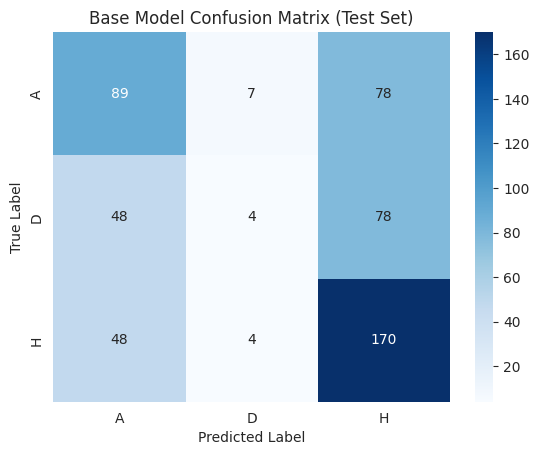


Base Model Classification Report:
              precision    recall  f1-score   support

           A       0.48      0.51      0.50       174
           D       0.27      0.03      0.06       130
           H       0.52      0.77      0.62       222

    accuracy                           0.50       526
   macro avg       0.42      0.44      0.39       526
weighted avg       0.45      0.50      0.44       526


Base Model Log Loss: 1.0342


In [13]:
# Cell 8: Base Model Training and Evaluation

print("Training the base Random Forest model with scaling...")

# Train the pipeline on the training data
model_pipeline.fit(X_train, y_train)

print("Base Random Forest model training complete.")

print("\nEvaluating the base Random Forest model on the test set...")

# Make predictions (class labels)
y_pred_base = model_pipeline.predict(X_test)

# Get predicted probabilities for each class
y_pred_proba_base = model_pipeline.predict_proba(X_test)

# Evaluate Metrics
accuracy_base = accuracy_score(y_test, y_pred_base)
conf_matrix_base = confusion_matrix(y_test, y_pred_base)
class_report_base = classification_report(y_test, y_pred_base, target_names=model_pipeline.classes_) # Use classes_ from the pipeline

# Calculate Log Loss
logloss_base = log_loss(y_test, y_pred_proba_base, labels=model_pipeline.classes_)


print(f"\nBase Model Accuracy: {accuracy_base:.4f}")
print("\nBase Model Confusion Matrix:")
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=model_pipeline.classes_, yticklabels=model_pipeline.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Base Model Confusion Matrix (Test Set)")
plt.show()


print("\nBase Model Classification Report:")
print(class_report_base)

print(f"\nBase Model Log Loss: {logloss_base:.4f}")

In [14]:
# Cell 9: Hyperparameter Tuning (RandomizedSearchCV)

print("Starting Hyperparameter Tuning using RandomizedSearchCV...")

# Define the parameter distribution for the classifier step in the pipeline
param_distributions = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(5, 25), # Increased max depth search range slightly
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 15), # Increased leaf search range slightly
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

# Define cross-validation strategy (StratifiedKFold on training data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_pipeline, # Use the pipeline as the estimator
    param_distributions=param_distributions,
    n_iter=75, # Number of search iterations (adjust based on time/resources)
    scoring='neg_log_loss', # Metric to optimize (lower is better, hence 'neg')
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    return_train_score=False
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

print("\nHyperparameter tuning complete.")
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score (Negative Log Loss): {random_search.best_score_:.4f}")

Starting Hyperparameter Tuning using RandomizedSearchCV...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END classifier__class_weight=None, classifier__max_depth=24, classifier__max_features=sqrt, classifier__min_samples_leaf=11, classifier__min_samples_split=9, classifier__n_estimators=288; total time=   1.1s
[CV] END classifier__class_weight=balanced, classifier__max_depth=8, classifier__max_features=None, classifier__min_samples_leaf=6, classifier__min_samples_split=3, classifier__n_estimators=443; total time=   4.1s
[CV] END classifier__class_weight=None, classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=3, classifier__min_samples_split=13, classifier__n_estimators=154; total time=   0.7s
[CV] END classifier__class_weight=balanced, classifier__max_depth=7, classifier__max_features=sqrt, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=120; total time=   0.4s
[CV] END classifier__class_

In [15]:
# Cell 10: Final Model Training with best parameters

print("Getting the final model pipeline with best parameters...")

# The best_estimator_ from RandomizedSearchCV is the final pipeline,
# already fitted on the entire training data (X_train, y_train).
final_pipeline = random_search.best_estimator_

print("Final model pipeline ready.")

Getting the final model pipeline with best parameters...
Final model pipeline ready.


Evaluating the FINAL model on the test set...

Final Model Accuracy: 0.5152

Final Model Confusion Matrix:


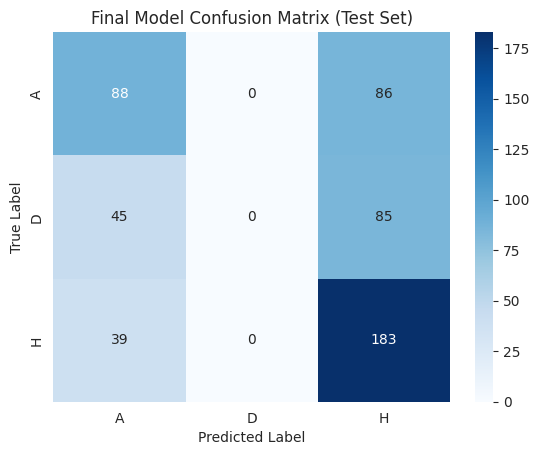


Final Model Classification Report:
              precision    recall  f1-score   support

           A       0.51      0.51      0.51       174
           D       0.00      0.00      0.00       130
           H       0.52      0.82      0.64       222

    accuracy                           0.52       526
   macro avg       0.34      0.44      0.38       526
weighted avg       0.39      0.52      0.44       526


Final Model Log Loss: 1.0093

Comparison of Metrics:
Base Accuracy: 0.5000 -> Final Accuracy: 0.5152
Base Log Loss: 1.0342 -> Final Log Loss: 1.0093
Best CV Negative Log Loss (Training): -1.0002


In [16]:
# Cell 11: Final Evaluation on Test Set

print("Evaluating the FINAL model on the test set...")

# Make predictions and get probabilities using the final pipeline
y_pred_final = final_pipeline.predict(X_test)
y_pred_proba_final = final_pipeline.predict_proba(X_test)

# Evaluate Metrics
accuracy_final = accuracy_score(y_test, y_pred_final)
conf_matrix_final = confusion_matrix(y_test, y_pred_final)
class_report_final = classification_report(y_test, y_pred_final, target_names=final_pipeline.classes_) # Use classes_ from the final pipeline

# Calculate Log Loss
logloss_final = log_loss(y_test, y_pred_proba_final, labels=final_pipeline.classes_)


print(f"\nFinal Model Accuracy: {accuracy_final:.4f}")
print("\nFinal Model Confusion Matrix:")
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', xticklabels=final_pipeline.classes_, yticklabels=final_pipeline.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Model Confusion Matrix (Test Set)")
plt.show()

print("\nFinal Model Classification Report:")
print(class_report_final)

print(f"\nFinal Model Log Loss: {logloss_final:.4f}")

print("\nComparison of Metrics:")
print(f"Base Accuracy: {accuracy_base:.4f} -> Final Accuracy: {accuracy_final:.4f}")
print(f"Base Log Loss: {logloss_base:.4f} -> Final Log Loss: {logloss_final:.4f}")
print(f"Best CV Negative Log Loss (Training): {random_search.best_score_:.4f}")

In [17]:
print("Saving the final model pipeline and preprocessors...")

# Define directory to save assets
save_dir = 'model_assets'
os.makedirs(save_dir, exist_ok=True)

# Save the final trained pipeline (includes scaler and tuned model)
model_pipeline_path = os.path.join(save_dir, 'full_prediction_pipeline.joblib')
joblib.dump(final_pipeline, model_pipeline_path)

# Save the fitted SimpleImputer used before the pipeline
# The imputer object was fitted on the full X in Cell 4.
imputer_path = os.path.join(save_dir, 'imputer.joblib')
joblib.dump(imputer, imputer_path) # Save the 'imputer' object created and fitted in Cell 4


print(f"Final model pipeline saved to: {model_pipeline_path}")
print(f"Fitted Imputer saved to: {imputer_path}")
print("\nSaved assets can be loaded for prediction.")

Saving the final model pipeline and preprocessors...
Final model pipeline saved to: model_assets/full_prediction_pipeline.joblib
Fitted Imputer saved to: model_assets/imputer.joblib

Saved assets can be loaded for prediction.


In [18]:
# Cell 13: Design the Prediction Pipeline Function

print("Designing the prediction pipeline function...")

# Re-define or ensure access to the get_rolling_stats_refined function and ROLLING_WINDOW
# This function was defined in Cell 3. Copy it here for the prediction function
# to be self-contained if run outside this notebook environment.
def get_rolling_stats_refined(team, match_date, df_sorted, window_size, location_filter=None):
    required_cols = ['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
                     'FullTimeHomeGoals', 'FullTimeAwayGoals',
                     'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                     'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                     'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
    # Add checks if columns are missing in df_sorted if needed for robustness

    team_matches = df_sorted[df_sorted['MatchDate'] < match_date].copy()
    team_matches_filtered = team_matches[(team_matches['HomeTeam'] == team) | (team_matches['AwayTeam'] == team)]

    if location_filter == 'Home':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['HomeTeam'] == team]
    elif location_filter == 'Away':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['AwayTeam'] == team]

    recent_matches = team_matches_filtered.sort_values(by='MatchDate').tail(window_size)

    if recent_matches.empty:
        return {}

    stats = {}
    valid_matches_results = recent_matches.dropna(subset=['FullTimeResult', 'HomeTeam', 'AwayTeam'])

    if not valid_matches_results.empty:
         points = valid_matches_results.apply(lambda row:
             3 if (row['HomeTeam'] == team and row['FullTimeResult'] == 'H') or \
                  (row['AwayTeam'] == team and row['FullTimeResult'] == 'A') else \
             1 if row['FullTimeResult'] == 'D' else \
             0, axis=1)
         stats['Points'] = points.mean()
    else:
         stats['Points'] = np.nan


    valid_matches_goals = recent_matches.dropna(subset=['FullTimeHomeGoals', 'FullTimeAwayGoals'])
    if not valid_matches_goals.empty:
        stats['GoalsScored'] = valid_matches_goals.apply(lambda row: row['FullTimeHomeGoals'] if row['HomeTeam'] == team else row['FullTimeAwayGoals'], axis=1).mean()
        stats['GoalsConceded'] = valid_matches_goals.apply(lambda row: row['FullTimeAwayGoals'] if row['HomeTeam'] == team else row['FullTimeHomeGoals'], axis=1).mean()
    else:
        stats['GoalsScored'] = np.nan
        stats['GoalsConceded'] = np.nan


    for col in ['Shots', 'ShotsOnTarget', 'Corners', 'Fouls', 'YellowCards', 'RedCards']:
        home_col = f'Home{col}'
        away_col = f'Away{col}'
        if home_col in recent_matches.columns and away_col in recent_matches.columns:
             valid_matches_stat = recent_matches.dropna(subset=[home_col, away_col])
             if not valid_matches_stat.empty:
                stats[col] = valid_matches_stat.apply(lambda row: row[home_col] if row['HomeTeam'] == team else row[away_col], axis=1).mean()
             else:
                stats[col] = np.nan
        else:
             stats[col] = np.nan

    return stats

# Ensure ROLLING_WINDOW is defined
# Make sure this matches the value used during training in Cell 3
ROLLING_WINDOW = 5

# Load the saved model and preprocessors for use in the function
save_dir = 'model_assets'
model_pipeline_path = os.path.join(save_dir, 'full_prediction_pipeline.joblib')
imputer_path = os.path.join(save_dir, 'imputer.joblib')

try:
    loaded_pipeline = joblib.load(model_pipeline_path)
    loaded_imputer = joblib.load(imputer_path)
    print("Model and preprocessors loaded successfully for prediction function.")
    # Get the list of expected features from the loaded pipeline's first step (scaler)
    # The scaler's number of features seen during fit determines the expected input size.
    # More reliably, we saved the list of columns in Cell 4 (as `features`).
    # Let's assume X (from Cell 4, after imputation) is available or reload if necessary.
    # In production, you'd save/load this list explicitly.
    try:
         expected_features = list(X.columns) # X was defined in Cell 4
         print(f"Prediction function expects {len(expected_features)} features.")
    except NameError:
         print("Error: X not found. Cannot determine expected features for prediction function.")
         print("Example prediction might fail. Ensure X was defined in Cell 4.")
         expected_features = []

except FileNotFoundError:
    print(f"Error: Model assets not found in {save_dir}. Run Cell 12 first.")
    loaded_pipeline = None
    loaded_imputer = None
    expected_features = [] # Cannot predict without knowing expected features

# --- The Prediction Function ---
def predict_epl_outcome(home_team, away_team, match_date_str, historical_df, model_pipeline, imputer, expected_features, window_size=5):
    """
    Predicts the outcome probabilities for a given EPL match using loaded assets.

    Args:
        home_team (str): Name of the home team.
        away_team (str): Name of the away team.
        match_date_str (str): Date of the match in 'YYYY-MM-DD' format.
        historical_df (pd.DataFrame): DataFrame containing historical match data,
                                     sorted by date and including all columns
                                     needed for rolling average calculation.
        model_pipeline: The loaded scikit-learn pipeline (including scaler and model).
        imputer: The loaded fitted SimpleImputer.
        expected_features (list): List of feature column names the model expects,
                                  in the correct order.
        window_size (int): The rolling window size used during training.

    Returns:
        dict: A dictionary containing the predicted probability for 'H', 'D', 'A'.
              Returns None if inputs are invalid or prediction fails.
    """
    if model_pipeline is None or imputer is None or not expected_features:
        print("Prediction failed: Model or preprocessors not loaded correctly.")
        return None

    try:
        match_date = pd.to_datetime(match_date_str)
    except ValueError:
        print(f"Error: Invalid match_date_str format: {match_date_str}. Use YYYY-MM-DD.")
        return None

    # Validate teams exist in historical data (optional but good practice)
    all_teams = pd.concat([historical_df['HomeTeam'], historical_df['AwayTeam']]).unique()
    if home_team not in all_teams or away_team not in all_teams:
        print(f"Error: One or both teams ('{home_team}', '{away_team}') not found in historical data.")
        return None

    # 1. Calculate rolling averages for the new match date and teams
    # Ensure historical_df is sorted by date
    historical_df_sorted = historical_df.sort_values(by='MatchDate').reset_index(drop=True)

    home_stats = get_rolling_stats_refined(home_team, match_date, historical_df_sorted, window_size, location_filter='Home')
    home_stats_overall = get_rolling_stats_refined(home_team, match_date, historical_df_sorted, window_size, location_filter=None)

    away_stats = get_rolling_stats_refined(away_team, match_date, historical_df_sorted, window_size, location_filter='Away')
    away_stats_overall = get_rolling_stats_refined(away_team, match_date, historical_df_sorted, window_size, location_filter=None)

    # Calculate combined attack vs defense features
    home_attack_away_defense = home_stats.get('GoalsScored', np.nan) - away_stats.get('GoalsConceded', np.nan)
    away_attack_home_defense = away_stats.get('GoalsScored', np.nan) - home_stats.get('GoalsConceded', np.nan)

    # 2. Create a DataFrame for the new match features
    match_features_dict = {
        f'HomeAvgLast{window_size}_GoalsScored_Home': home_stats.get('GoalsScored', np.nan),
        f'HomeAvgLast{window_size}_GoalsConceded_Home': home_stats.get('GoalsConceded', np.nan),
        f'HomeAvgLast{window_size}_ShotsOnTarget_Home': home_stats.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{window_size}_Corners_Home': home_stats.get('Corners', np.nan),
        f'HomeAvgLast{window_size}_YellowCards_Home': home_stats.get('YellowCards', np.nan),
        f'HomeAvgLast{window_size}_Points_Home': home_stats.get('Points', np.nan),

        f'AwayAvgLast{window_size}_GoalsScored_Away': away_stats.get('GoalsScored', np.nan),
        f'AwayAvgLast{window_size}_GoalsConceded_Away': away_stats.get('GoalsConceded', np.nan),
        f'AwayAvgLast{window_size}_ShotsOnTarget_Away': away_stats.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{window_size}_Corners_Away': away_stats.get('Corners', np.nan),
        f'AwayAvgLast{window_size}_YellowCards_Away': away_stats.get('YellowCards', np.nan),
        f'AwayAvgLast{window_size}_Points_Away': away_stats.get('Points', np.nan),

        f'HomeAvgLast{window_size}_GoalsScored_Overall': home_stats_overall.get('GoalsScored', np.nan),
        f'HomeAvgLast{window_size}_GoalsConceded_Overall': home_stats_overall.get('GoalsConceded', np.nan),
        f'HomeAvgLast{window_size}_ShotsOnTarget_Overall': home_stats_overall.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{window_size}_Points_Overall': home_stats_overall.get('Points', np.nan),

        f'AwayAvgLast{window_size}_GoalsScored_Overall': away_stats_overall.get('GoalsScored', np.nan),
        f'AwayAvgLast{window_size}_GoalsConceded_Overall': away_stats_overall.get('GoalsConceded', np.nan),
        f'AwayAvgLast{window_size}_ShotsOnTarget_Overall': away_stats_overall.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{window_size}_Points_Overall': away_stats_overall.get('Points', np.nan),

        f'HomeAttack_vs_AwayDefense_{window_size}Avg': home_attack_away_defense,
        f'AwayAttack_vs_HomeDefense_{window_size}Avg': away_attack_home_defense,
    }

    # Create DataFrame ensuring correct column order and presence
    X_new = pd.DataFrame([match_features_dict])
    X_new = X_new.reindex(columns=expected_features) # Reindex to match training columns

    # 3. Impute missing values
    X_new_imputed_array = imputer.transform(X_new)
    X_new_imputed = pd.DataFrame(X_new_imputed_array, columns=X_new.columns, index=X_new.index)

    # 4. Make the probability prediction using the pipeline (includes scaling)
    prediction_proba_array = model_pipeline.predict_proba(X_new_imputed)

    # 5. Format the output
    class_labels = model_pipeline.classes_
    prediction_proba_dict = dict(zip(class_labels, prediction_proba_array[0]))

    return prediction_proba_dict

# --- Example Usage ---
# Assuming 'df' (original historical data, sorted) is available in the environment
# and loaded_pipeline, loaded_imputer, expected_features are available from above

if loaded_pipeline is not None and loaded_imputer is not None and expected_features:
    print("\n--- Example Prediction ---")
    # Let's try predicting a match
    example_home_team = 'Liverpool'
    example_away_team = 'Man City'
    # Choose a date *after* the latest date in your training data
    # For robustness, get the latest date from the training data used
    latest_train_date = df.loc[X_train.index[-1], 'MatchDate']
    example_match_date = latest_train_date + pd.Timedelta(days=7) # Example date 7 days after last train match
    example_match_date_str = example_match_date.strftime('%Y-%m-%d')

    # Ensure teams exist in the historical data
    all_teams_in_df = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
    if example_home_team in all_teams_in_df and example_away_team in all_teams_in_df:
         print(f"Predicting match: {example_home_team} vs {example_away_team} on {example_match_date_str}")

         predicted_probabilities = predict_epl_outcome(
             home_team=example_home_team,
             away_team=example_away_team,
             match_date_str=example_match_date_str,
             historical_df=df, # Pass the full historical data
             model_pipeline=loaded_pipeline,
             imputer=loaded_imputer,
             expected_features=expected_features,
             window_size=ROLLING_WINDOW
         )

         if predicted_probabilities:
             print("\nPredicted Probabilities:")
             print(predicted_probabilities)
             predicted_outcome = max(predicted_probabilities, key=predicted_probabilities.get)
             print(f"Most likely outcome: {predicted_outcome}")
         else:
             print("Example prediction failed.")
    else:
        print(f"\nSkipping example prediction: One or both teams ('{example_home_team}', '{example_away_team}') not found in historical data.")


else:
    print("\nCannot run example prediction: Model, preprocessors, or feature list not loaded correctly.")

Designing the prediction pipeline function...
Model and preprocessors loaded successfully for prediction function.
Prediction function expects 20 features.

--- Example Prediction ---
Predicting match: Liverpool vs Man City on 2024-01-27

Predicted Probabilities:
{'A': np.float64(0.27639256394945344), 'D': np.float64(0.24768382289891977), 'H': np.float64(0.475923613151627)}
Most likely outcome: H
